# Explorative data analysis

0. Import libraries & load data
1. Describe data
2. Prepare data
3. Simple model training


In this notebook we only do one basic training to get a baseline
 

In [1]:
%cd ..

/home/frischs/huk_coburg_coding_challenge


In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re
from nltk.corpus import stopwords
import nltk

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix

from transformers import DistilBertTokenizer
import pickle


In [3]:
DATA_PATH = "data"
train_path = os.path.join(DATA_PATH, "training.csv")
valid_path = os.path.join(DATA_PATH, "validation.csv")

In [4]:
column_names = ["id", "product", "label", "comment"]
train_data = pd.read_csv(train_path, header=0, names=column_names)
valid_data = pd.read_csv(valid_path, header=0, names=column_names)

## 1. Describe
- basic checks:
    - leading white spaces in comments
- duplicated rows and NaNs only in train
- label distribution is very similar between train and valid
- Product


In [5]:
train_data.head()

,id,product,label,comment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       74681 non-null  int64 
 1   product  74681 non-null  object
 2   label    74681 non-null  object
 3   comment  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


Missing and NaNs

In [7]:
def duplicate_or_nans(data: pd.DataFrame) -> None:
    duplicate_count = data.duplicated().sum()
    missing_values = data.isnull().sum()

    print(f"Number of duplicate rows: {duplicate_count}")
    print(f"Missing values:\n{missing_values}")

print("Training data:")
duplicate_or_nans(train_data)
print("\nValidation data:")
duplicate_or_nans(valid_data)

Training data:
Number of duplicate rows: 2700
Missing values:
id           0
product      0
label        0
comment    686
dtype: int64

Validation data:
Number of duplicate rows: 0
Missing values:
id         0
product    0
label      0
comment    0
dtype: int64


Label distribution

In [8]:
train_data.label.value_counts() / len(train_data)

label
Negative      0.301844
Positive      0.278933
Neutral       0.245283
Irrelevant    0.173940
Name: count, dtype: float64

In [9]:
valid_data.label.value_counts() / len(valid_data)

label
Neutral       0.285285
Positive      0.277277
Negative      0.266266
Irrelevant    0.171171
Name: count, dtype: float64

What is product are they the same between train and valid?
- 32 products and they are the same in train and valid
product == id? 
- it seems like the 6 comments per id are the same comments mostly but transformed:
    - upper lower case 
    - different words 
- might be worth it to train only on 1 variation

In [10]:
train_unique_products = train_data["product"].unique()
print(f"Number of unique products in training data: {len(train_unique_products)}")
print(f"Unique products in training data: {train_unique_products}")

Number of unique products in training data: 32
Unique products in training data: ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']


In [11]:
set(train_data["product"].unique()) == set(valid_data["product"].unique())

True

In [12]:
train_data.groupby('product')['id'].value_counts()

product          id  
Amazon           1       6
                 2       6
                 3       6
                 4       6
                 5       6
                        ..
johnson&johnson  7196    6
                 7197    6
                 7198    6
                 7199    6
                 7200    6
Name: count, Length: 12447, dtype: int64

Sentiment distribution over the different products

<Figure size 1500x800 with 0 Axes>

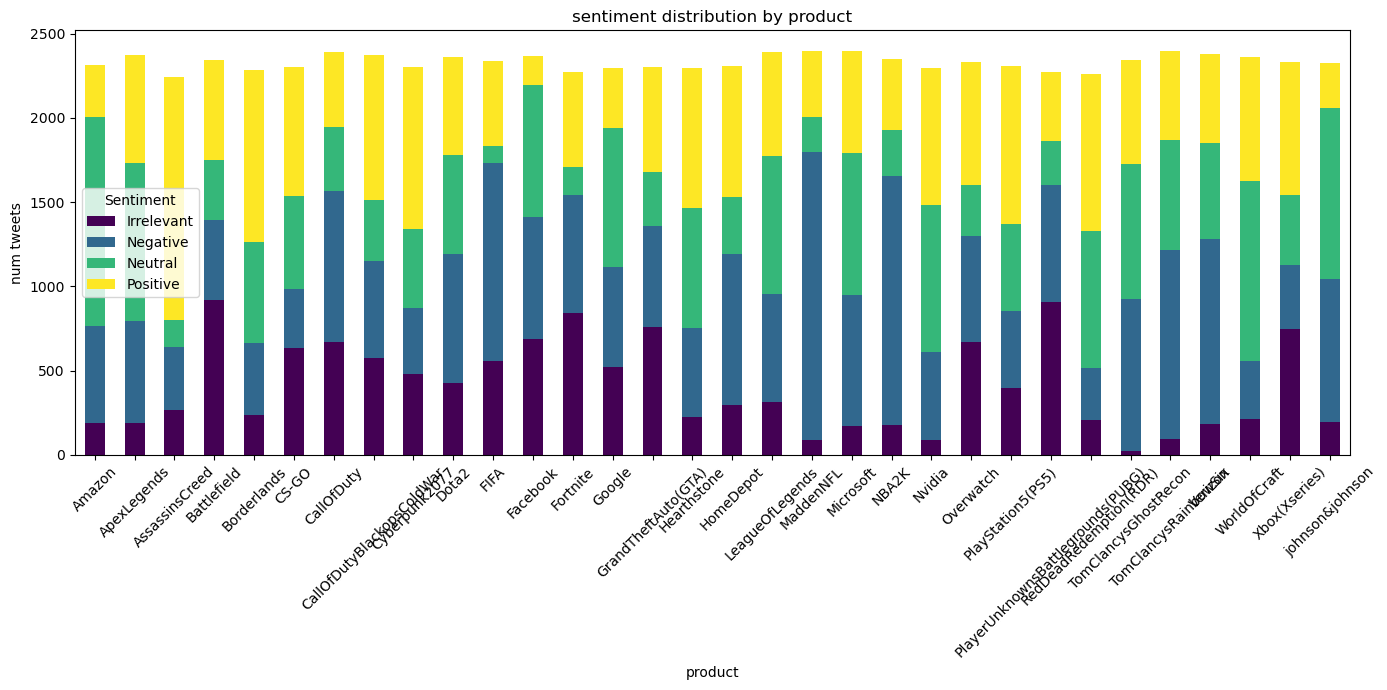

In [13]:
product_sentiment_crosstab = pd.crosstab(train_data['product'], train_data['label'])

plt.figure(figsize=(15, 8))
product_sentiment_crosstab.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 7))
plt.title('sentiment distribution by product')
plt.xlabel('product')
plt.ylabel('num tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

Length of comments

In [14]:
def histo_plot_lengths(lengths):
    """
    Plots a histogram of lengths.
    
    Args:
    - lenghts: List[int], list of lengths per comment.
    """

    # Creating the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, bins=30)
    
    plt.title('Distribution of Lengths per Comment')
    plt.xlabel('Length')
    plt.ylabel('Number of Comments')
    plt.show()



## 2. Transforming
- label encoder -> maybe exclude irrelevant label
- clean text: remove leading and trailing whitespaces
-

In [15]:
label_encoder = LabelEncoder()
train_data['encoded_label'] = label_encoder.fit_transform(train_data['label'])
valid_data['encoded_label'] = label_encoder.transform(valid_data['label'])

# print encoded labels to original labels
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
label_mapping

{0: 'Irrelevant', 1: 'Negative', 2: 'Neutral', 3: 'Positive'}

In [16]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(
        text: str,
        lower: bool = True,
        letters_numbers_only: str = r"[^a-zA-Z0-9]",
        stop_words: set = None
    ) -> str:
    """
    Clean text by removing special characters, numbers, and stopwords.

    - lower: bool, default=True
    - letters_numbers_only: str, default=r"[^a-zA-Z0-9]"
    - stop_words: set, default=None
    """
    
    if not isinstance(text, str):
        return np.nan

    # strip leading/trailing whitespaces
    text = text.strip()
    text = text.replace('"', '') 
    
    if lower:
        text = text.lower()
    if letters_numbers_only is not None:
        text = re.sub(letters_numbers_only, " ", text)
    if stop_words is not None:
        text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

train_data['cleaned_comment'] = train_data['comment'].apply(lambda x: clean_text(x, stop_words=None))
valid_data['cleaned_comment'] = valid_data['comment'].apply(lambda x: clean_text(x, stop_words=None))

train_data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/frischs/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,product,label,comment,encoded_label,cleaned_comment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,3,i am coming to the borders and i will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,3,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,3,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,3,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,3,im getting into borderlands and i can murder y...


## 3. Prepare data for training
- drop duplicates and NaNs in train (no need to do in valid)
- split into train, valid, test 
    - since we have a separate validation set we use this for testing
    - split train 80/20 


In [17]:
initial_size = len(train_data)
train_data = train_data.drop_duplicates()
train_data = train_data.dropna(subset=['cleaned_comment'])
print(f"Removed {initial_size - len(train_data)} duplicates and empty lines")

Removed 3026 duplicates and empty lines


In [18]:
# Stratified split
train_df, valid_df = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data['encoded_label'],
    random_state=42
)
test_df = valid_data

## Model training

build baseline with Naive Bayes


In [19]:
X_train, y_train = train_df['cleaned_comment'], train_df['encoded_label']
X_valid, y_valid = valid_df['cleaned_comment'], valid_df['encoded_label']
X_test, y_test = test_df['cleaned_comment'], test_df['encoded_label']

In [21]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
with open('saved_models/naive_bayes.pkl', 'wb') as file:       
    pickle.dump(model, file) 

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# F1 score
print(f"F1 macro: {f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

  Irrelevant       0.98      0.59      0.74       171
    Negative       0.67      0.92      0.78       266
     Neutral       0.90      0.67      0.76       285
    Positive       0.78      0.88      0.83       277

    accuracy                           0.78       999
   macro avg       0.83      0.77      0.78       999
weighted avg       0.82      0.78      0.78       999

F1 macro: 0.7760364882782139


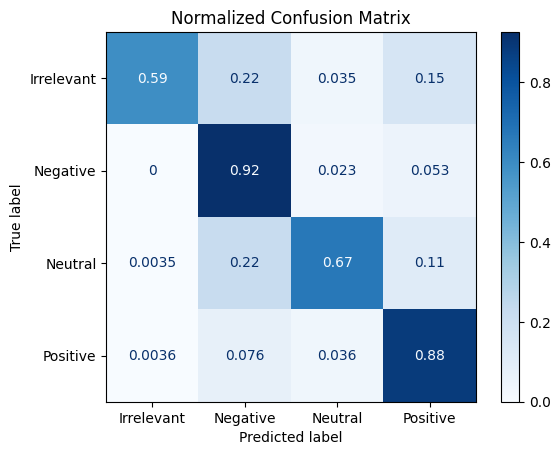

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    display_labels=label_encoder.classes_,
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("Normalized Confusion Matrix")

plt.show()

## Transformers check num tokens
Length of tokens

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
comments = train_data['cleaned_comment'].tolist()
lengths = [len(tokenizer.encode(comment, add_special_tokens=False)) for comment in comments]

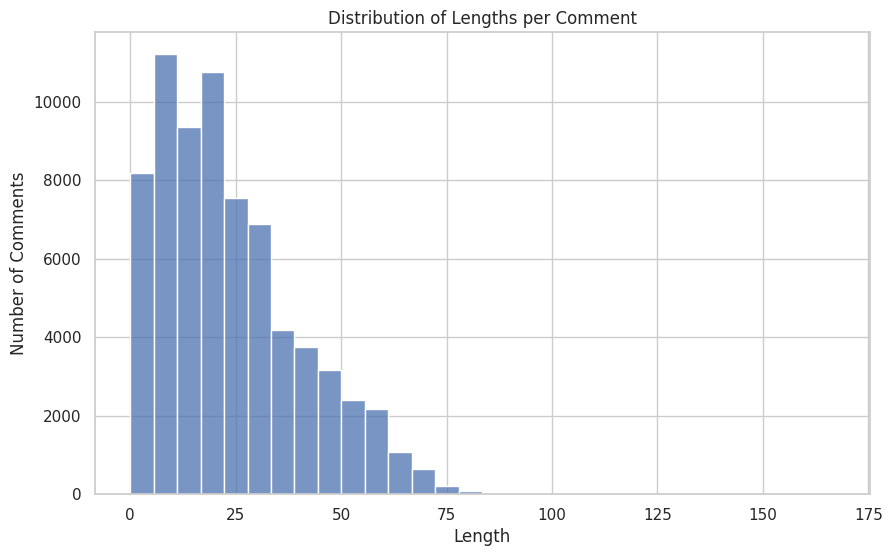

In [ ]:
histo_plot_lengths(lengths)
